<a href="https://colab.research.google.com/github/SeanEwanDalton/Neobank_Le_Wagon_Project/blob/main/Neobank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Analytics

## Importing the datasets

In [ ]:
!pip install google-cloud-bigquery


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.cloud import bigquery
from google.colab import files
import os
# Upload the JSON key file and set the environment variable
uploaded = files.upload()
key_path = list(uploaded.keys())[0]
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

# Create the BigQuery client
client = bigquery.Client()


Saving massive-tea-384708-6ae7b719a87c.json to massive-tea-384708-6ae7b719a87c (1).json


Importing info_user_engagement dataset

In [ ]:
import pandas as pd
df_engagement = pd.read_gbq('massive-tea-384708.neo_bank.info_users_engagement')
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15078 entries, 0 to 15077
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 15078 non-null  object
 1   Q1_transaction_count    15078 non-null  Int64 
 2   Q2_transaction_count    15078 non-null  Int64 
 3   Q3_transaction_count    15078 non-null  Int64 
 4   Q4_transaction_count    15078 non-null  Int64 
 5   retention_days          15078 non-null  Int64 
 6   activation_time         15078 non-null  Int64 
 7   membership_duration     15078 non-null  Int64 
 8   retention_quartile      15078 non-null  Int64 
 9   transaction_count       15078 non-null  Int64 
 10  transaction_quartile    15078 non-null  Int64 
 11  user_segment            15078 non-null  object
 12  Q1_engagement_category  15078 non-null  Int64 
 13  Q2_engagement_category  15078 non-null  Int64 
 14  Q3_engagement_category  15078 non-null  Int64 
 15  Q4

Importing merged_devices_users_transactions dataset

In [ ]:
df_merged = pd.read_gbq('massive-tea-384708.neo_bank.merged_devices_users_transactions_table')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325342 entries, 0 to 1325341
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   user_id                    1325342 non-null  object 
 1   device_brand               1325342 non-null  object 
 2   age                        1325342 non-null  Int64  
 3   user_country               1325342 non-null  object 
 4   user_created_date          1325342 non-null  dbdate 
 5   crypto_users               1325342 non-null  object 
 6   user_plan                  1325342 non-null  object 
 7   push_notification_status   1325342 non-null  object 
 8   email_notification_status  1325342 non-null  object 
 9   num_contacts               1325342 non-null  Int64  
 10  transaction_id             1325342 non-null  object 
 11  transaction_date           1325342 non-null  dbdate 
 12  transactions_state         1325342 non-null  object 
 13  transactions

##Data Cleaning

Modifying the columns transaction_id to be integers

In [ ]:
df_merged['transaction_id'] = df_merged['transaction_id'].str.extract('(\d+)', expand=False).astype(int)
df_merged.head()

,user_id,device_brand,age,user_country,user_created_date,crypto_users,user_plan,push_notification_status,email_notification_status,num_contacts,transaction_id,transaction_date,transactions_state,transactions_type,amount_usd,direction,age_group,cohort
0,user_4732,Apple,62,GB,2018-04-13,No,STANDARD,NA,NA,0,860,2019-02-24,COMPLETED,CARD_PAYMENT,18.60,OUTBOUND,60.0,2018-04
1,user_7832,Apple,65,GB,2018-06-21,No,STANDARD,NA,NA,0,4250,2019-04-30,COMPLETED,CARD_PAYMENT,13.34,OUTBOUND,60.0,2018-06
2,user_1390,Apple,69,GB,2018-02-02,No,STANDARD,Yes,Yes,19,1533,2018-11-22,COMPLETED,CARD_PAYMENT,4.66,OUTBOUND,60.0,2018-02
3,user_7832,Apple,65,GB,2018-06-21,No,STANDARD,NA,NA,0,4246,2019-04-29,COMPLETED,CARD_PAYMENT,8.27,OUTBOUND,60.0,2018-06
4,user_18548,Apple,73,GB,2018-12-12,Yes,STANDARD,Yes,Yes,8,1755247,2019-01-26,COMPLETED,CARD_PAYMENT,48.76,OUTBOUND,70.0,2018-12


Modifying the columns to get numerals values

In [ ]:
df_merged['push_notification_status'] = df_merged['push_notification_status'].replace({'Yes': 1, 'No': 0})
df_merged['email_notification_status'] = df_merged['email_notification_status'].replace({'Yes': 1, 'No': 0})

#A/B Testing

AB-testing the hypothesis: if the customers has enabled email_notification_status and push_notification_status they are more likely to do more transactions.

In [ ]:
from scipy import stats

control_group = df_merged[(df_merged['push_notification_status'] == 0) & (df_merged['email_notification_status'] == 0)]
test_group = df_merged[(df_merged['push_notification_status'] == 1) & (df_merged['email_notification_status'] == 1)]


control_transactions = control_group['transaction_id'].count()
test_transactions = test_group['transaction_id'].count()
control_spend = control_group['amount_usd'].sum()
test_spend = test_group['amount_usd'].sum()

t_stat, p_value = stats.ttest_ind(control_group['amount_usd'], test_group['amount_usd'])

print("Control Group:")
print("Transactions:", control_transactions)
print("Total Spend:", control_spend)

print("Test Group:")
print("Transactions:", test_transactions)
print("Total Spend:", test_spend)

print("Statistical Analysis:")
print("t-statistic:", t_stat)
print("p-value:", p_value)


Control Group:
Transactions: 53170
Total Spend: 1159302.11
Test Group:
Transactions: 793086
Total Spend: 16854375.61
Statistical Analysis:
t-statistic: 2.6446468563495262
p-value: 0.008177772190853281


Based on the statistical analysis, the t-statistic value of 2.645 and the p-value of 0.008 suggest that there is a statistically significant difference between the control group (users with no push or email notifications enabled) and the test group (users with both push and email notifications enabled) in terms of the total spend.

Since the p-value is less than 0.05, we can conclude that there is evidence to support the hypothesis that enabling push and email notifications leads to a higher total spend. In other words, users who have both push and email notifications enabled tend to spend significantly more than users who have no notifications enabled.

Merging what is possible to merge in the two datasets.

In [ ]:
import pandas as pd

# Group df_merged by user_id and combine the other columns
df_merged_grouped = df_merged.groupby('user_id').agg({
    'device_brand': 'first',
    'age': 'first',
    'user_country': 'first',
    'user_created_date': 'first',
    'crypto_users': 'first',
    'user_plan': 'first',
    'push_notification_status': 'first',
    'email_notification_status': 'first',
    'num_contacts': 'first'
}).reset_index()

merged_df = df_engagement.merge(df_merged_grouped, on='user_id', how='inner')
merged_df.head()


,user_id,Q1_transaction_count,Q2_transaction_count,Q3_transaction_count,Q4_transaction_count,retention_days,activation_time,membership_duration,retention_quartile,transaction_count,...,yearly_engagement,device_brand,age,user_country,user_created_date,crypto_users,user_plan,push_notification_status,email_notification_status,num_contacts
0,user_0,4,72,35,25,335,139,474,4,136,...,medium_users,Apple,34,PL,2018-01-13,Yes,STANDARD,1,1,3
1,user_10,43,85,83,71,355,133,488,4,282,...,active_users,Apple,43,FR,2018-01-04,No,STANDARD,1,1,38
2,user_100,25,11,29,3,297,180,477,4,68,...,medium_users,Apple,54,GB,2018-01-15,No,STANDARD,NA,NA,0
3,user_10000,25,22,8,9,263,7,270,4,64,...,medium_users,Android,64,PL,2018-08-13,No,STANDARD,1,1,41
4,user_10004,16,12,2,36,222,25,247,3,66,...,active_users,Apple,24,LT,2018-08-31,No,STANDARD,1,1,9


#Machine Learning

##Data Clean

Modification of the data in order to perform the machine learning

In [ ]:
merged_df['push_notification_status'] = merged_df['push_notification_status'].replace('NA', merged_df['push_notification_status'].mode()[0])

merged_df['email_notification_status'] = merged_df['email_notification_status'].replace('NA', merged_df['email_notification_status'].mode()[0])

merged_df['device_brand'] = merged_df['device_brand'].replace({'Apple': 1, 'Android': 0})

merged_df['crypto_users'] = merged_df['crypto_users'].replace({'Yes': 1, 'No': 0})

merged_df['user_plan'] = merged_df['user_plan'].replace({'METAL': 1, 'STANDARD': 0,'PREMIUM':2})


##Correlation Matrix

Correlation matrix of all the variables to determine which columns to use for the prediction of the yearly engagement

<ipython-input-29-a4bcf19916b8>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_merged_df = correlation_merged_df.corr()


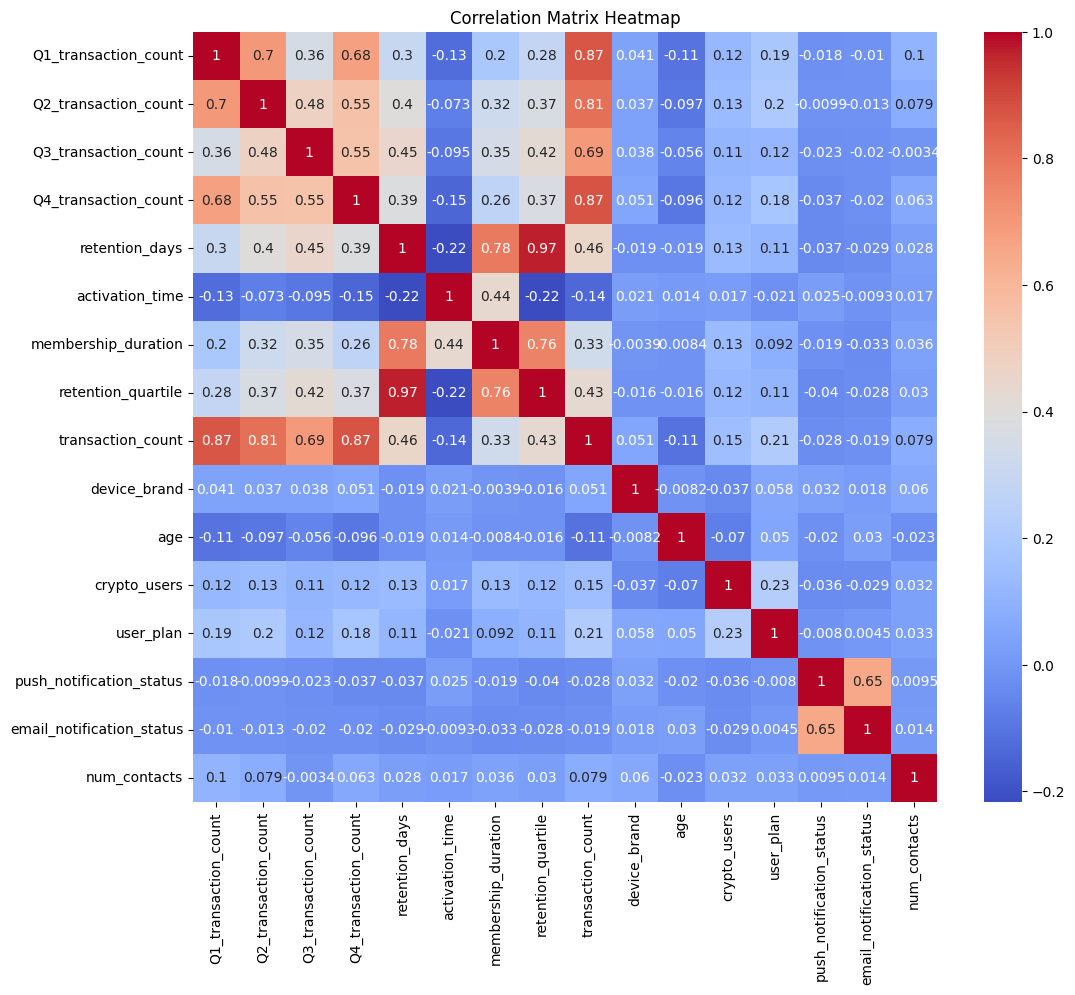

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['user_id','Q1_transaction_count','Q2_transaction_count','Q3_transaction_count','Q4_transaction_count','retention_days','activation_time',
'membership_duration','retention_quartile','transaction_count','device_brand','age','user_country','user_created_date',
'crypto_users','user_plan','push_notification_status','email_notification_status','num_contacts']


correlation_merged_df = merged_df[columns]

correlation_matrix_merged_df = correlation_merged_df.corr()

# Create a heatmap using the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_merged_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


##Predictive User Engagement Time Series Modelling




Testing which variables are going to be the most relevant in the prediction of the yearly engagement

In [ ]:
from sklearn.ensemble import RandomForestClassifier

columns_to_test = ['Q1_transaction_count', 'Q2_transaction_count', 'Q3_transaction_count', 'Q4_transaction_count',
                   'retention_days', 'activation_time', 'membership_duration', 'retention_quartile', 'transaction_count',
                   'device_brand', 'age', 'crypto_users', 'user_plan',
                   'push_notification_status', 'email_notification_status', 'num_contacts']

X = merged_df[columns_to_test]
y = merged_df['yearly_engagement']

rf = RandomForestClassifier()
rf.fit(X, y)

feature_importances = rf.feature_importances_

for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")


Q1_transaction_count: 0.13175183028651202
Q2_transaction_count: 0.10170371034102335
Q3_transaction_count: 0.07989625285203272
Q4_transaction_count: 0.13681850685204583
retention_days: 0.09341364267071665
activation_time: 0.01850727950948962
membership_duration: 0.03606109839887141
retention_quartile: 0.037327215171568805
transaction_count: 0.32248749542718663
device_brand: 0.0032951983603065967
age: 0.016104501401826895
crypto_users: 0.0025130406908538973
user_plan: 0.0027046347980292447
push_notification_status: 0.001244269908526436
email_notification_status: 0.001383704388861235
num_contacts: 0.01478761894214868


The transaction-related features (Q1_transaction_count, Q2_transaction_count, Q3_transaction_count, Q4_transaction_count, and transaction_count) have relatively high importance scores, indicating that they are significant predictors of yearly engagement.
Other features like retention_days, membership_duration, and retention_quartile also have some importance in predicting yearly engagement.
Features like activation_time, device_brand, age, crypto_users, user_plan, push_notification_status, email_notification_status, and num_contacts have lower importance scores, indicating they have less impact on predicting yearly engagement.


Prediction of the yearly engagement for the next year based on the most relevant periods

Accuracy: 0.855106100795756
Precision: 0.8535831187046503
Recall: 0.855106100795756
F1-score: 0.853902142798075


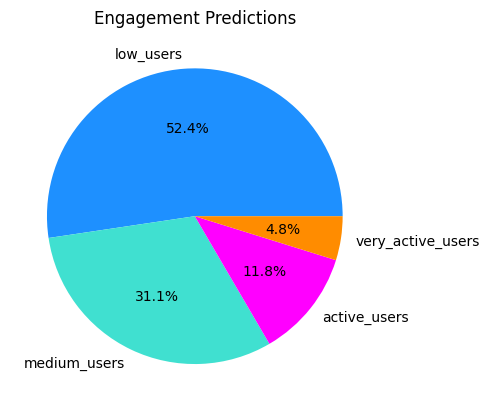

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

merged_df['avg_transaction_count'] = merged_df[['Q1_transaction_count', 'Q2_transaction_count', 'Q3_transaction_count', 'Q4_transaction_count']].mean(axis=1)

X = merged_df[['avg_transaction_count','transaction_count', 'retention_days', 'membership_duration']]
y = merged_df['yearly_engagement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


engagement = pd.Series(y_pred).value_counts()
labels = engagement.index.tolist()
values = engagement.values.tolist()
colors = ['dodgerblue', 'turquoise', 'magenta', 'darkorange']


plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title("Engagement Predictions")
plt.show()

Accuracy: It represents the overall correctness of the model's predictions. 79.24% of the predictions are correct.

Precision: It measures the proportion of correctly predicted positive instances (true positives) out of all instances predicted as positive (true positives + false positives). 79.21% of the predicted positive instances were actually positive.

Recall: It measures the proportion of correctly predicted positive instances (true positives) out of all actual positive instances (true positives + false negatives). 79.24% of the actual positive instances were correctly identified.

F1-score: It is the harmonic mean of precision and recall and provides a single metric that combines both. The F1-score of 0.7922 indicates the balance between precision and recall, where higher values indicate better performance.